In [2]:
#im skipping leap days currently in multiple places
import sys
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn
import random
import json
import pickle
import time
import copy

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
months = {1: "jan", 2: "feb", 3: "mar", 4: "apr", 5: "may", 6: "jun", 7: "jul", 8: "aug", 9: "sep", 10: "oct", 11: "nov", 12: "dec"}

startdate = datetime.datetime(year=2010, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

allhours = []

while curr < enddate:
    allhours.append(curr)
    curr += datetime.timedelta(hours=1)
    
trainhours = allhours[0:-8760] #all but last year, not a leap year
testhours = allhours[-8760:]
print(len(allhours))
print(len(trainhours))
print(len(testhours))

70128
61368
8760


In [4]:
#ERCOT data
subregions = ['COAST', 'EAST', 'FAR_WEST', 'NORTH', 'NORTH_C', 'SOUTHERN', 'SOUTH_C', 'WEST', 'ERCOT']
other_subregions = ['COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'ERCOT']


lds = datetime.datetime(year=2016, month=2, day=29, hour=0, minute=0) #lines 1415 to 1439
lde = datetime.datetime(year=2016, month=2, day=29, hour=23, minute=0)

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx") #different subregions Index(['Hour Ending', 'COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'ERCOT'],dtype='object')
ercot2016 = pd.read_excel(path + "native_Load_2016.xlsx") #leap year
#ercot2016.drop(ercot2016.index[1415:1439], inplace=True)

ercot2015 = pd.read_excel(path + "native_Load_2015.xls")
ercot2014 = pd.read_excel(path + "2014_ERCOT_Hourly_Load_Data.xls")
ercot2013 = pd.read_excel(path + "2013_ERCOT_Hourly_Load_Data.xls")
ercot2012 = pd.read_excel(path + "2012_ERCOT_Hourly_Load_Data.xls") #leap year
#ercot2012.drop(ercot2012.index[1415:1439], inplace=True)

ercot2011 = pd.read_excel(path + "2011_ERCOT_Hourly_Load_Data.xls")
ercot2010 = pd.read_excel(path + "2010_ERCOT_Hourly_Load_Data.xls")

#ercotdata = list(ercot2010['ERCOT']) + list(ercot2011['ERCOT']) + list(ercot2012['ERCOT']) + list(ercot2013['ERCOT']) + list(ercot2014['ERCOT']) + list(ercot2015['ERCOT']) + list(ercot2016['ERCOT']) + list(ercot2017['ERCOT'])
yearly_data = {}
yearly_data['ERCOT'] = [list(ercot2010['ERCOT']), list(ercot2011['ERCOT']), list(ercot2012['ERCOT']), list(ercot2013['ERCOT']), list(ercot2014['ERCOT']), list(ercot2015['ERCOT']), list(ercot2016['ERCOT']), list(ercot2017['ERCOT'])]

for region in subregions:
    yearly_data[region] = [list(ercot2010[region]), list(ercot2011[region]), list(ercot2012[region]), list(ercot2013[region]), list(ercot2014[region]), list(ercot2015[region]), list(ercot2016[region])]

for region in other_subregions:
    r = subregions[other_subregions.index(region)]
    yearly_data[r].append(list(ercot2017[region]))

In [5]:
#for subregions
vectorized_subregions = {}
for region in subregions:
    vectorized_subregions[region] = {}
    train_data_vec = np.array(yearly_data[region][0]) - np.mean(yearly_data[region][0])
    means = [np.mean(yearly_data[region][0])]
    for i in range(1, len(yearly_data[region])-1):
        yr = yearly_data[region][i]
        m = np.nanmean(yr)
        means.append(m)
        train_data_vec = np.concatenate((train_data_vec, np.array(yr)-m), axis=0)
        
    vectorized_subregions[region]['train_data'] = train_data_vec    
    vectorized_subregions[region]['means'] = means
        
    

In [6]:
for region in subregions:
    #if switching back to monthly labels output feature engineered data elsewhere
    #train_data_vec = vectorized_subregions[region]['train_data']
    
    train_data_vals = []
    #train_data_labels = []
    train_data_labels = np.array([])
    #m = 0
    
    """
    for i in range(len(trainhours)):
        if trainhours[i].month - 1 == m and i != len(trainhours) - 1:
            train_data_vals.append(train_data_vec[i,])
        elif i == len(trainhours) - 1:
            train_data_vals.append(train_data_vec[i,])
            for val in train_data_vals:
                greater = np.sum([1 for k in train_data_vals if k >= val])/float(len(train_data_vals))
                train_data_labels.append(1.0 - greater)
        else:
            for val in train_data_vals:
                greater = np.sum([1 for k in train_data_vals if k >= val])/float(len(train_data_vals))
                train_data_labels.append(1.0 - greater)

            train_data_vals = []
            train_data_vals.append(train_data_vec[i,]) #start with missed value
            m = (m + 1) % 12
    vectorized_subregions[region]['train_labels'] = np.array(train_data_labels)
            
    """
    for i in range(len(yearly_data[region])-1):
        year_data = yearly_data[region][i]
        train_data_l = np.zeros((len(year_data),))
        for j in range(len(year_data)):
            greater = np.sum([1 for k in year_data if k >= year_data[j]])/float(len(year_data))
            train_data_l[j] = 1.0 - greater
        train_data_labels = np.concatenate((train_data_labels, train_data_l), axis=0)
            
    vectorized_subregions[region]['train_labels'] = train_data_labels

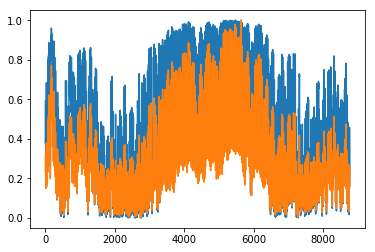

In [19]:
a = 0 #not neccessarily a true month so load value normalization is off in plot
b = 8760
plt.plot(vectorized_subregions[region]['train_labels'][a:b])
plt.plot( (vectorized_subregions[region]['train_data'][a:b,]  - np.min(vectorized_subregions[region]['train_data'][a:b,]))/ (np.max(vectorized_subregions[region]['train_data'][a:b,]) - np.min(vectorized_subregions[region]['train_data'][a:b,])) )

In [8]:
y = vectorized_subregions[region]['train_labels'][a:b]
x = (vectorized_subregions[region]['train_data'][a:b,]  - np.min(vectorized_subregions[region]['train_data'][a:b,]))/ (np.max(vectorized_subregions[region]['train_data'][a:b,]) - np.min(vectorized_subregions[region]['train_data'][a:b,]))

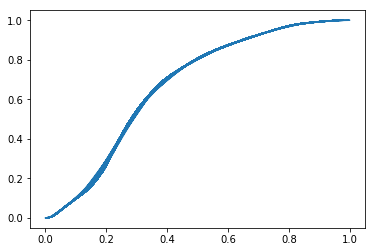

In [13]:
plt.plot(x,y)

In [22]:
y = vectorized_subregions[region]['train_labels'][a:b]
x = (vectorized_subregions[region]['train_data'][a:b,]  - np.min(vectorized_subregions[region]['train_data'][a:b,]))/ (np.max(vectorized_subregions[region]['train_data'][a:b,]) - np.min(vectorized_subregions[region]['train_data'][a:b,]))

In [14]:
#use system-wide loadgrowth for all regions for mean shifting
for region in vectorized_subregions:
    A = np.vstack((np.array([0, 1, 2, 3, 4, 5, 6]), np.array([1, 1, 1, 1, 1, 1, 1]))).T
    a, b = np.linalg.lstsq(A, np.array(vectorized_subregions[region]['means']))[0]
    print(a, b)
    projected_mean = a*7.0 + b
    vectorized_subregions[region]['projected_mean'] = projected_mean

202.21956698167793 10330.675211917747
1.1445290359099922 1389.0497308542554
157.5580701856505 1235.861525615093
-6.286314908476045 862.2773959771353
55.294436102682454 12689.296038363827
74.74464079097235 2906.584283652104
69.80779480723267 6095.32943668585
14.267152541100186 1046.8526042098674
568.7498755367494 36555.92622727587


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [15]:
for region in vectorized_subregions:
    test_data_vec = np.array(yearly_data[region][-1]) - vectorized_subregions[region]['projected_mean']
    vectorized_subregions[region]['test_data'] = test_data_vec

In [16]:
for region in subregions:
    
    #train_data_vec = vectorized_subregions[region]['train_data']
    
    test_data_vals = []
    #train_data_labels = []
    #m = 0
    
    year_data = yearly_data[region][-1]
    test_data_l = np.zeros((len(year_data),))
    for j in range(len(year_data)):
        greater = np.sum([1 for k in year_data if k >= year_data[j]])/float(len(year_data))
        test_data_l[j] = 1.0 - greater
            
    vectorized_subregions[region]['test_labels'] = test_data_l

"""
for region in vectorized_subregions:
    test_data_vec = vectorized_subregions[region]['test_data']
    
    test_data_vals = []
    test_data_labels = []
    m = 0
    
    for i in range(len(testhours)):
        if testhours[i].month - 1 == m and i != len(testhours) - 1:
            test_data_vals.append(test_data_vec[i,])
        elif i == len(testhours) - 1:
            test_data_vals.append(test_data_vec[i,])
            for val in test_data_vals:
                greater = np.sum([1 for k in test_data_vals if k >= val])/float(len(test_data_vals))
                test_data_labels.append(1.0 - greater)
        else:
            for val in test_data_vals:
                greater = np.sum([ 1 for k in test_data_vals if k >= val ])/float(len(test_data_vals))
                test_data_labels.append(1.0 - greater)
                
            test_data_vals = []
            test_data_vals.append(test_data_vec[i,])
            m = (m + 1) % 12
    vectorized_subregions[region]['test_labels'] = np.array(test_data_labels)
"""

"\nfor region in vectorized_subregions:\n    test_data_vec = vectorized_subregions[region]['test_data']\n    \n    test_data_vals = []\n    test_data_labels = []\n    m = 0\n    \n    for i in range(len(testhours)):\n        if testhours[i].month - 1 == m and i != len(testhours) - 1:\n            test_data_vals.append(test_data_vec[i,])\n        elif i == len(testhours) - 1:\n            test_data_vals.append(test_data_vec[i,])\n            for val in test_data_vals:\n                greater = np.sum([1 for k in test_data_vals if k >= val])/float(len(test_data_vals))\n                test_data_labels.append(1.0 - greater)\n        else:\n            for val in test_data_vals:\n                greater = np.sum([ 1 for k in test_data_vals if k >= val ])/float(len(test_data_vals))\n                test_data_labels.append(1.0 - greater)\n                \n            test_data_vals = []\n            test_data_vals.append(test_data_vec[i,])\n            m = (m + 1) % 12\n    vectorized_subr

In [24]:
y_test = vectorized_subregions[region]['test_labels'][a:b]
x_test = (vectorized_subregions[region]['test_data'][a:b,]  - np.min(vectorized_subregions[region]['train_data'][a:b,]))/ (np.max(vectorized_subregions[region]['train_data'][a:b,]) - np.min(vectorized_subregions[region]['train_data'][a:b,]))

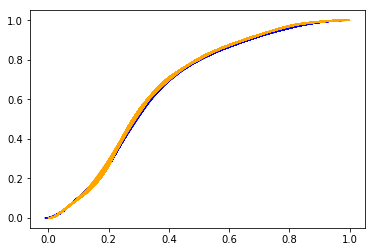

In [27]:
plt.plot(x_test,y_test, color="blue")
plt.plot(x, y, color="orange")

In [21]:
for region in vectorized_subregions:
    print(vectorized_subregions[region]['train_data'].shape, vectorized_subregions[region]['test_data'].shape, vectorized_subregions[region]['train_labels'].shape, vectorized_subregions[region]['test_labels'].shape)

(61368,) (8760,) (61368,) (8760,)
(61368,) (8760,) (61368,) (8760,)
(61368,) (8760,) (61368,) (8760,)
(61368,) (8760,) (61368,) (8760,)
(61368,) (8760,) (61368,) (8760,)
(61368,) (8760,) (61368,) (8760,)
(61368,) (8760,) (61368,) (8760,)
(61368,) (8760,) (61368,) (8760,)
(61368,) (8760,) (61368,) (8760,)


In [22]:
#normalize load values
for region in vectorized_subregions:
    train_max = np.nanmax(vectorized_subregions[region]['train_data'])
    train_min = np.nanmin(vectorized_subregions[region]['train_data'])
    
    vectorized_subregions[region]['train_data_norm'] = (vectorized_subregions[region]['train_data'] - train_min)/(train_max - train_min)
    vectorized_subregions[region]['test_data_norm'] = (vectorized_subregions[region]['train_data'] - train_min)/(train_max - train_min)

In [80]:
def itermean(oldmean, newval, num):
    if np.isnan(newval):
        out = oldmean
    elif np.isnan(oldmean) and not np.isnan(newval):
        out = newval
    else:
        out = oldmean + ((newval - oldmean)/float(num))
    return(out)

def itervar(oldvar, oldmean, newval, num):
    if np.isnan(newval):
        out = oldvar
    else:
        n = float(num)
        out = ((n - 1)*oldvar + (newval - oldmean)*(newval - oldmean))/n
    return(out)

In [81]:
all_loads = np.concatenate((vectorized_subregions['ERCOT']['train_data'], vectorized_subregions['ERCOT']['test_data']))
print(all_loads.shape)
print(len(allhours))
print(len(testhours))
print(len(trainhours))

(70128,)
70128
8760
61368


In [82]:
def init_matching():
    out = {}
    for h in range(24):
        out[h] = [np.nan]
    return(out)

In [83]:
list(vectorized_subregions.keys())[2:-1]

['FAR_WEST', 'NORTH', 'NORTH_C', 'SOUTHERN', 'SOUTH_C', 'WEST']

In [84]:
reorg_regions = ['ERCOT'] + list(vectorized_subregions.keys())[:-1] #['ERCOT'] + list(vectorized_subregions.keys())[4:-1] #ercot and east are done
print(reorg_regions)

['ERCOT', 'COAST', 'EAST', 'FAR_WEST', 'NORTH', 'NORTH_C', 'SOUTHERN', 'SOUTH_C', 'WEST']


In [89]:
#do this for 'ERCOT' only

seasons = {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2, 10: 3, 11: 3, 12: 3}

for region in reorg_regions:
    load_features = {}
    print(region)
    all_loads = np.concatenate((vectorized_subregions[region]['train_data_norm'], vectorized_subregions[region]['test_data_norm']))
    
    maxsofar = all_loads[0,]
    meansofar = all_loads[0,]
    varsofar = 0.0
    count = 0
    year = 2010
    month = 1
    
    for i in range(len(allhours)):
        load_features[str(allhours[i])] = {}
        currtime = allhours[i]
        curr_year = currtime.year
        #curr_month = currtime.month

        if curr_year > year:
            print(curr_year)
            year = curr_year
            maxsofar = all_loads[i,]
            meansofar = all_loads[i,]
            varsofar = 0.0
            count = 0
        else:
            count += 1
            if all_loads[i] > maxsofar:
                maxsofar = all_loads[i]
            varsofar = itervar(varsofar, meansofar, all_loads[i], count)
            meansofar = itermean(meansofar, all_loads[i], count)
            
        """
        elif curr_month == 1 and month == 12:
            print(curr_month, currtime.year)
            month = curr_month
            maxsofar = all_loads[i,]
            meansofar = all_loads[i,]
            varsofar = 0.0
            count = 0
        """
        
        
        dt_back = currtime
        dayback = 28
        stop_1 = currtime - datetime.timedelta(days=dayback)
        #stop_2 = currtime - datetime.timedelta(days=30*2)

        #the while loop is horrible
        if region == "ERCOT":
            try:
                h = currtime.hour
                for t in range(24):
                    mhour = [ all_loads[allhours.index((currtime - datetime.timedelta(hours=t)) - datetime.timedelta(hours=24*i))] for i in range(dayback) ]
                    load_features[str(currtime)]["hourmax_" + str((h-t)%24)] = np.nanmax(mhour)
                    load_features[str(currtime)]["hourmin_" + str((h-t)%24)] = np.nanmin(mhour)
                    load_features[str(currtime)]["hourmean_" + str((h-t)%24)] = np.nanmean(mhour)
                    load_features[str(currtime)]["hourvar_" + str((h-t)%24)] = np.nanvar(mhour)
                    hhist = np.histogram(mhour, bins=7, range=(np.nanmin(mhour), np.nanmax(mhour)))[0]
                    load_features[str(currtime)]["hourhist_" + str((h-t)%24)] = list((1.0/sum(hhist)) * hhist)
            except Exception as err:
                print(err)
                matching_hour = init_matching()
                while dt_back > stop_1:
                    if dt_back < allhours[0]:
                        break
                    else:
                        matching_hour[dt_back.hour].append(all_loads[allhours.index(dt_back)])
                    dt_back -= datetime.timedelta(hours=1)

                for hour in range(24):
                    if len(matching_hour[hour]) == 0:
                        load_features[str(currtime)]["hourhist_" + str(hour)] = list(np.nan * np.zeros((7,)))
                        load_features[str(currtime)]["hourmax_" + str(hour)] = np.nan
                        load_features[str(currtime)]["hourmin_" + str(hour)] = np.nan
                        load_features[str(currtime)]["hourmean_" + str(hour)] = np.nan
                        load_features[str(currtime)]["hourvar_" + str(hour)] = np.nan
                    else:
                        try:
                            hhist = np.histogram(matching_hour[hour], bins=7, range=(np.nanmin(matching_hour[hour], np.nanmax(matching_hour[hour]))))[0]
                            hhist = (1.0/sum(hhist)) * hhist
                        except Exception as err:
                            hhist = np.nan * np.zeros((7,))
                        load_features[str(currtime)]["hourhist_" + str(hour)] = list(hhist)
                        load_features[str(currtime)]["hourmax_" + str(hour)] = np.nanmax(matching_hour[hour])
                        load_features[str(currtime)]["hourmin_" + str(hour)] = np.nanmin(matching_hour[hour])
                        load_features[str(currtime)]["hourmean_" + str(hour)] = np.nanmean(matching_hour[hour])
                        load_features[str(currtime)]["hourvar_" + str(hour)] = np.nanvar(matching_hour[hour])
        """
        #dhhist = np.histogram(loads_dayhour, bins=7, range=(np.nanmin(loads_dayhour), np.nanmax(loads_dayhour)))[0]
        #dayhourhist = (1.0/sum(dhhist)) * dhhist
        #hhist = np.histogram(loads_hour, bins=7, range=(np.nanmin(loads_hour), np.nanmax(loads_hour)))[0]
        #hourhist = (1.0/sum(hhist)) * hhist

        #load_features[currtime]["dayhourmax"] = dayhourmax #1
        #load_features[currtime]["dayhourmin"] = dayhourmin #1
        #load_features[currtime]["dayhourhist"] = dayhourhist #7
        #load_features[currtime]["dayhourmean"] = dayhourmean #1
        #load_features[currtime]["dayhourvar"] = dayhourvar #1
        #load_features[currtime]["hourmax"] = hourmax #1
        #load_features[currtime]["hourmin"] = hourmin #1
        #load_features[currtime]["hourhist"] = hourhist #7
        #load_features[currtime]["hourmean"] = hourmean #1
        #load_features[currtime]["hourvar"] = hourvar #1
        """
        load_features[str(currtime)]["load"] = all_loads[allhours.index(currtime)]
        load_features[str(currtime)]["maxloadsofar"] = maxsofar #1
        load_features[str(currtime)]["meanloadsofar"] = meansofar #1
        load_features[str(currtime)]["varsofar"] = varsofar #1
        load_features[str(currtime)]["hour"] = float(currtime.hour)/23.0
        load_features[str(currtime)]["month"] = float(currtime.month - 1.0)/11.0 #1
        load_features[str(currtime)]["week"] = float(currtime.isocalendar()[1])/52.0 #1
        load_features[str(currtime)]["weekday"] = float(currtime.weekday())/6.0 #1
        load_features[str(currtime)]["season"] = float(seasons[currtime.month])/3.0 #1
        
        
    with open("/home/chase/projects/peakload/data/ercot/" + region + "_load_features.json", 'w') as d:
        out = json.dumps(load_features)
        d.write(out)

ERCOT
datetime.datetime(2009, 12, 31, 0, 0) is not in list
datetime.datetime(2009, 12, 31, 1, 0) is not in list
datetime.datetime(2009, 12, 31, 2, 0) is not in list
datetime.datetime(2009, 12, 31, 3, 0) is not in list
datetime.datetime(2009, 12, 31, 4, 0) is not in list
datetime.datetime(2009, 12, 31, 5, 0) is not in list
datetime.datetime(2009, 12, 31, 6, 0) is not in list
datetime.datetime(2009, 12, 31, 7, 0) is not in list
datetime.datetime(2009, 12, 31, 8, 0) is not in list
datetime.datetime(2009, 12, 31, 9, 0) is not in list
datetime.datetime(2009, 12, 31, 10, 0) is not in list
datetime.datetime(2009, 12, 31, 11, 0) is not in list
datetime.datetime(2009, 12, 31, 12, 0) is not in list
datetime.datetime(2009, 12, 31, 13, 0) is not in list
datetime.datetime(2009, 12, 31, 14, 0) is not in list
datetime.datetime(2009, 12, 31, 15, 0) is not in list
datetime.datetime(2009, 12, 31, 16, 0) is not in list
datetime.datetime(2009, 12, 31, 17, 0) is not in list
datetime.datetime(2009, 12, 31, 

/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:84: RuntimeWarning: All-NaN axis encountered
/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:89: RuntimeWarning: All-NaN axis encountered
/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:90: RuntimeWarning: All-NaN axis encountered
/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:91: RuntimeWarning: Mean of empty slice
/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:92: RuntimeWarning: Degrees of freedom <= 0 for slice.


datetime.datetime(2009, 12, 31, 8, 0) is not in list
datetime.datetime(2009, 12, 31, 9, 0) is not in list
datetime.datetime(2009, 12, 31, 10, 0) is not in list
datetime.datetime(2009, 12, 31, 11, 0) is not in list
datetime.datetime(2009, 12, 31, 12, 0) is not in list
datetime.datetime(2009, 12, 31, 13, 0) is not in list
datetime.datetime(2009, 12, 31, 14, 0) is not in list
datetime.datetime(2009, 12, 31, 15, 0) is not in list
datetime.datetime(2009, 12, 31, 16, 0) is not in list
datetime.datetime(2009, 12, 31, 17, 0) is not in list
datetime.datetime(2009, 12, 31, 18, 0) is not in list
datetime.datetime(2009, 12, 31, 19, 0) is not in list
datetime.datetime(2009, 12, 31, 20, 0) is not in list
datetime.datetime(2009, 12, 31, 21, 0) is not in list
datetime.datetime(2009, 12, 31, 22, 0) is not in list
datetime.datetime(2009, 12, 31, 23, 0) is not in list
datetime.datetime(2009, 12, 31, 0, 0) is not in list
datetime.datetime(2009, 12, 31, 1, 0) is not in list
datetime.datetime(2009, 12, 31, 

datetime.datetime(2009, 12, 31, 22, 0) is not in list
datetime.datetime(2009, 12, 31, 23, 0) is not in list
datetime.datetime(2009, 12, 31, 0, 0) is not in list
datetime.datetime(2009, 12, 31, 1, 0) is not in list
datetime.datetime(2009, 12, 31, 2, 0) is not in list
datetime.datetime(2009, 12, 31, 3, 0) is not in list
datetime.datetime(2009, 12, 31, 4, 0) is not in list
datetime.datetime(2009, 12, 31, 5, 0) is not in list
datetime.datetime(2009, 12, 31, 6, 0) is not in list
datetime.datetime(2009, 12, 31, 7, 0) is not in list
datetime.datetime(2009, 12, 31, 8, 0) is not in list
datetime.datetime(2009, 12, 31, 9, 0) is not in list
datetime.datetime(2009, 12, 31, 10, 0) is not in list
datetime.datetime(2009, 12, 31, 11, 0) is not in list
datetime.datetime(2009, 12, 31, 12, 0) is not in list
datetime.datetime(2009, 12, 31, 13, 0) is not in list
datetime.datetime(2009, 12, 31, 14, 0) is not in list
datetime.datetime(2009, 12, 31, 15, 0) is not in list
datetime.datetime(2009, 12, 31, 16, 0)

datetime.datetime(2009, 12, 31, 15, 0) is not in list
datetime.datetime(2009, 12, 31, 16, 0) is not in list
datetime.datetime(2009, 12, 31, 17, 0) is not in list
datetime.datetime(2009, 12, 31, 18, 0) is not in list
datetime.datetime(2009, 12, 31, 19, 0) is not in list
datetime.datetime(2009, 12, 31, 20, 0) is not in list
datetime.datetime(2009, 12, 31, 21, 0) is not in list
datetime.datetime(2009, 12, 31, 22, 0) is not in list
datetime.datetime(2009, 12, 31, 23, 0) is not in list
datetime.datetime(2009, 12, 31, 0, 0) is not in list
datetime.datetime(2009, 12, 31, 1, 0) is not in list
datetime.datetime(2009, 12, 31, 2, 0) is not in list
datetime.datetime(2009, 12, 31, 3, 0) is not in list
datetime.datetime(2009, 12, 31, 4, 0) is not in list
datetime.datetime(2009, 12, 31, 5, 0) is not in list
datetime.datetime(2009, 12, 31, 6, 0) is not in list
datetime.datetime(2009, 12, 31, 7, 0) is not in list
datetime.datetime(2009, 12, 31, 8, 0) is not in list
datetime.datetime(2009, 12, 31, 9, 0)

datetime.datetime(2009, 12, 31, 11, 0) is not in list
datetime.datetime(2009, 12, 31, 12, 0) is not in list
datetime.datetime(2009, 12, 31, 13, 0) is not in list
datetime.datetime(2009, 12, 31, 14, 0) is not in list
datetime.datetime(2009, 12, 31, 15, 0) is not in list
datetime.datetime(2009, 12, 31, 16, 0) is not in list
datetime.datetime(2009, 12, 31, 17, 0) is not in list
datetime.datetime(2009, 12, 31, 18, 0) is not in list
datetime.datetime(2009, 12, 31, 19, 0) is not in list
datetime.datetime(2009, 12, 31, 20, 0) is not in list
datetime.datetime(2009, 12, 31, 21, 0) is not in list
datetime.datetime(2009, 12, 31, 22, 0) is not in list
datetime.datetime(2009, 12, 31, 23, 0) is not in list
datetime.datetime(2009, 12, 31, 0, 0) is not in list
datetime.datetime(2009, 12, 31, 1, 0) is not in list
datetime.datetime(2009, 12, 31, 2, 0) is not in list
datetime.datetime(2009, 12, 31, 3, 0) is not in list
datetime.datetime(2009, 12, 31, 4, 0) is not in list
datetime.datetime(2009, 12, 31, 5

2011
2012
2013
2014
2015
2016


/home/chase/applications/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/chase/applications/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


2017
COAST
2011
2012
2013
2014
2015
2016
2017
EAST
2011
2012
2013
2014
2015
2016
2017
FAR_WEST
2011
2012
2013
2014
2015
2016
2017
NORTH
2011
2012
2013
2014
2015
2016
2017
NORTH_C
2011
2012
2013
2014
2015
2016
2017
SOUTHERN
2011
2012
2013
2014
2015
2016
2017
SOUTH_C
2011
2012
2013
2014
2015
2016
2017
WEST
2011
2012
2013
2014
2015
2016
2017


In [92]:
load_features[str(trainhours[1000])]

{'hour': 0.6956521739130435,
 'load': 0.5772493052300539,
 'maxloadsofar': 0.9092093829734761,
 'meanloadsofar': 0.4203741308657636,
 'month': 0.09090909090909091,
 'season': 0.0,
 'varsofar': 0.021695441627968173,
 'week': 0.11538461538461539,
 'weekday': 0.5}

In [ ]:
np.histogram(a, bins=10, range=None, normed=False, weights=None, density=None)

In [ ]:
load_features[str(currtime)]

In [10]:
regions= list(vectorized_subregions.keys())
print(regions)

['COAST', 'EAST', 'FAR_WEST', 'NORTH', 'NORTH_C', 'SOUTHERN', 'SOUTH_C', 'WEST', 'ERCOT']


In [11]:
#reload feature data
regional_load_features = []
for region in regions: #['ERCOT']:#regions:
    with open("/home/chase/projects/peakload/data/ercot/" + region + "_load_features.json", 'r') as d:
        load_features = json.load(d)
        regional_load_features.append(load_features)
    
features = sorted(load_features[str(allhours[0])].keys())
trunc_features = ['load'] #, 'maxloadsofar', 'meanloadsofar', 'varsofar']
print(features)

['hour', 'hourhist_0', 'hourhist_1', 'hourhist_10', 'hourhist_11', 'hourhist_12', 'hourhist_13', 'hourhist_14', 'hourhist_15', 'hourhist_16', 'hourhist_17', 'hourhist_18', 'hourhist_19', 'hourhist_2', 'hourhist_20', 'hourhist_21', 'hourhist_22', 'hourhist_23', 'hourhist_3', 'hourhist_4', 'hourhist_5', 'hourhist_6', 'hourhist_7', 'hourhist_8', 'hourhist_9', 'hourmax_0', 'hourmax_1', 'hourmax_10', 'hourmax_11', 'hourmax_12', 'hourmax_13', 'hourmax_14', 'hourmax_15', 'hourmax_16', 'hourmax_17', 'hourmax_18', 'hourmax_19', 'hourmax_2', 'hourmax_20', 'hourmax_21', 'hourmax_22', 'hourmax_23', 'hourmax_3', 'hourmax_4', 'hourmax_5', 'hourmax_6', 'hourmax_7', 'hourmax_8', 'hourmax_9', 'hourmean_0', 'hourmean_1', 'hourmean_10', 'hourmean_11', 'hourmean_12', 'hourmean_13', 'hourmean_14', 'hourmean_15', 'hourmean_16', 'hourmean_17', 'hourmean_18', 'hourmean_19', 'hourmean_2', 'hourmean_20', 'hourmean_21', 'hourmean_22', 'hourmean_23', 'hourmean_3', 'hourmean_4', 'hourmean_5', 'hourmean_6', 'hourme

In [ ]:
times = list(load_features.keys())
test_times = times[-8760:]

In [ ]:
str(trainhours[i])

In [94]:
"hourhist_12"[0:8]

'hourhist'

In [23]:
regions[r]

'ERCOT'

In [13]:
#training data input arrays, output_arrays 24 hours ahead
lookback = 24*28
training_data_pairs = []
midnight_training_data_pairs = []
midnight_daymax_training_data_pairs = []
ercot_training_data_pairs = []
midnight_ercot_training_data_pairs = []
midnight_daymax_ercot_training_data_pairs = []

#need to do more feature engineering in here

for i in range(len(trainhours)-(24 + 1)):
    if i%1000 == 0:
        print(i)
    data_point = []
    e_data_point = []
    for r in range(len(regional_load_features)):
        if regions[r] == 'ERCOT':
            for f in range(len(features)):
                feat = features[f]
                if feat[0:8] == "hourhist":
                    vals = regional_load_features[r][str(trainhours[i])][feat]
                    for val in vals:
                        data_point.append(val)
                        e_data_point.append(val)
                else:
                    val = regional_load_features[r][str(trainhours[i])][feat]
                    if np.isnan(val):
                        try:
                            interp = []
                            for k in range(3):
                                t_f = str(trainhours[i-j+k])
                                t_b = str(trainhours[i-j-k])
                                v_f = regional_load_features[r][t_f][feat]
                                v_b = regional_load_features[r][t_b][feat]
                                interp.append(v_f)
                                interp.append(v_b)
                            val = np.nanmean(interp) 
                        except:
                            pass
                    data_point.append(val)
                    e_data_point.append(val)  
            for j in range(lookback):
                for f in range(len(trunc_features)):
                    feat = trunc_features[f]
                    t = trainhours[i-j]
                    val = regional_load_features[r][str(t)][feat]
                    if np.isnan(val):
                        try:
                            interp = []
                            for k in range(3):
                                t_f = str(trainhours[i-j+k])
                                t_b = str(trainhours[i-j-k])
                                v_f = regional_load_features[r][t_f][feat]
                                v_b = regional_load_features[r][t_b][feat]
                                interp.append(v_f)
                                interp.append(v_b)
                            val = np.nanmean(interp)
                        except:
                            pass
                    data_point.append(val)
                    e_data_point.append(val)
        else:
            for j in range(lookback):
                for f in range(len(trunc_features)):
                    feat = trunc_features[f]
                    t = trainhours[i-j]
                    val = regional_load_features[r][str(t)][feat]
                    if np.isnan(val):
                        try:
                            interp = []
                            for k in range(3):
                                t_f = str(trainhours[i-j+k])
                                t_b = str(trainhours[i-j-k])
                                v_f = regional_load_features[r][t_f][feat]
                                v_b = regional_load_features[r][t_b][feat]
                                interp.append(v_f)
                                interp.append(v_b)
                            val = np.nanmean(interp)
                        except:
                            pass
                    data_point.append(val)
        
    label = np.zeros((24,))
    if trainhours[i].hour == 0:
        max_label = np.zeros((24,))
    for j in range(24):
        label[j,] = vectorized_subregions['ERCOT']['train_labels'][(i + 1) + j]
        if trainhours[i].hour == 0:
            max_label[j,] = vectorized_subregions['ERCOT']['train_data_norm'][(i + 1) + j]
    training_data_pairs.append((np.array(data_point), label)) 
    ercot_training_data_pairs.append((np.array(e_data_point), label))
    
    if trainhours[i].hour == 0:
        midnight_training_data_pairs.append((np.array(data_point), label))
        midnight_daymax_training_data_pairs.append((np.array(data_point), (trainhours[i], np.nanmax(max_label))))
        midnight_ercot_training_data_pairs.append((np.array(e_data_point), label))
        midnight_daymax_ercot_training_data_pairs.append((np.array(e_data_point), (trainhours[i], np.nanmax(max_label))))

0


KeyError: 'train_labels'

In [155]:
r, str(trainhours[i]), feat

(8, '2016-12-30 22:00:00', 'load')

In [156]:
training_data_pairs[0][0].shape, training_data_pairs[0][1].shape

((6321,), (24,))

In [157]:
training_data_pairs[1000][0], training_data_pairs[1000][1]

(array([0.40434432, 0.40365768, 0.39895331, ..., 0.32825258, 0.33456016,
        0.30210486]),
 array([0.82203196, 0.84828767, 0.84497717, 0.82968037, 0.79531963,
        0.73550228, 0.66883562, 0.60570776, 0.57534247, 0.56552511,
        0.57180365, 0.61575342, 0.69977169, 0.77842466, 0.8033105 ,
        0.79634703, 0.79406393, 0.77853881, 0.76347032, 0.74417808,
        0.72614155, 0.70228311, 0.69018265, 0.68847032]))

In [158]:
#process daymax data, do CDF ranking for each month index in daymax data pairs second element
dmaxdists = {}
for pair in midnight_daymax_training_data_pairs:
    key = str(pair[1][0].year) #+ str(pair[1][0].month)
    if key not in dmaxdists:
        dmaxdists[key] = [pair[1][1]]
    else:
        dmaxdists[key].append(pair[1][1])

In [159]:
len(dmaxdists['2010'])

365

In [160]:
midnight_daymax_training_data_pairs_copy = []
midnight_daymax_ercot_training_data_pairs_copy = []
out = []

for p in range(len(midnight_daymax_training_data_pairs)):
    key = str(midnight_daymax_training_data_pairs[p][1][0].year) #+ "_" + str(midnight_daymax_training_data_pairs[p][1][0].month)
    val = midnight_daymax_training_data_pairs[p][1][1]
    rank = 1.0 - (np.sum( [ 1 for k in dmaxdists[key] if k >= val ] )/float(len(dmaxdists[key])))
    midnight_daymax_training_data_pairs_copy.append((midnight_daymax_training_data_pairs[p][0], np.array([rank])))
    midnight_daymax_ercot_training_data_pairs_copy.append((midnight_daymax_ercot_training_data_pairs[p][0], np.array([rank])))
    out.append(rank)

In [161]:
for i in range(len(training_data_pairs)):
    with open("/home/chase/projects/peakload/data/ercot/regional_formatted/load_features/train/" + str(i) + "_load_features_training_data_pairs.pck", 'wb') as d:
        pickle.dump(training_data_pairs[i], d)
    
for i in range(len(midnight_training_data_pairs)):
    with open("/home/chase/projects/peakload/data/ercot/regional_formatted/midnight_load_features/train/" + str(i) + "_midnight_load_features_training_data_pairs.pck", 'wb') as d:
        pickle.dump(midnight_training_data_pairs[i], d)
    
for i in range(len(midnight_daymax_training_data_pairs_copy)):
    with open("/home/chase/projects/peakload/data/ercot/regional_formatted/midnight_daymax_load_features/train/" + str(i) + "_midnight_daymax_load_features_training_data_pairs.pck", 'wb') as d:
        pickle.dump(midnight_daymax_training_data_pairs_copy[i], d)
    
for i in range(len(ercot_training_data_pairs)):
    with open("/home/chase/projects/peakload/data/ercot/formatted/load_features/train/" + str(i) + "_load_features_training_data_pairs.pck", 'wb') as d:
        pickle.dump(ercot_training_data_pairs[i], d)
    
for i in range(len(midnight_ercot_training_data_pairs)):
    with open("/home/chase/projects/peakload/data/ercot/formatted/midnight_load_features/train/" + str(i) + "_midnight_load_features_training_data_pairs.pck", 'wb') as d:
        pickle.dump(midnight_ercot_training_data_pairs[i], d)

for i in range(len(midnight_daymax_ercot_training_data_pairs_copy)):
    with open("/home/chase/projects/peakload/data/ercot/formatted/midnight_daymax_load_features/train/" + str(i) + "_midnight_daymax_load_features_training_data_pairs.pck", 'wb') as d:
        pickle.dump(midnight_daymax_ercot_training_data_pairs_copy[i], d)


In [162]:
with open("/home/chase/projects/peakload/data/ercot/formatted/load_features/train/9_load_features_training_data_pairs.pck", 'rb') as d:
    data = pickle.load(d)
    
print(data)

(array([3.91304348e-01,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
     

In [23]:
#lookback = 24*14
test_data_pairs = []
midnight_test_data_pairs = []
midnight_daymax_test_data_pairs = []
ercot_test_data_pairs = []
midnight_ercot_test_data_pairs = []
midnight_daymax_ercot_test_data_pairs = []


for i in range(len(testhours)-(24 + 1)):
    if i%1000 == 0:
        print(i)
    data_point = []
    e_data_point = []
    for r in range(len(regional_load_features)):
        if regions[r] == 'ERCOT': #8: #ercot
            for f in range(len(features)):
                feat = features[f]
                if feat[0:8] == "hourhist":
                    vals = regional_load_features[r][str(testhours[i])][feat]
                    for val in vals:
                        data_point.append(val)
                        e_data_point.append(val)
                else:
                    val = regional_load_features[r][str(testhours[i])][feat]
                    if np.isnan(val):
                        try:
                            interp = []
                            for k in range(3):
                                t_f = str(testhours[i-j+k])
                                t_b = str(testhours[i-j-k])
                                v_f = regional_load_features[r][t_f][feat]
                                v_b = regional_load_features[r][t_b][feat]
                                interp.append(v_f)
                                interp.append(v_b)
                            val = np.nanmean(interp) 
                        except:
                            pass
                    data_point.append(val)
                    e_data_point.append(val)
            for j in range(lookback):
                for f in range(len(trunc_features)):
                    feat = trunc_features[f]
                    t = testhours[i-j]
                    val = regional_load_features[r][str(t)][feat]
                    if np.isnan(val):
                        interp = []
                        for k in range(3):
                            t_f = str(testhours[i-j+k])
                            t_b = str(testhours[i-j-k])
                            v_f = regional_load_features[r][t_f][feat]
                            v_b = regional_load_features[r][t_b][feat]
                            interp.append(v_f)
                            interp.append(v_b)
                        val = np.nanmean(interp)
                    data_point.append(val)
                    e_data_point.append(val)
        else:
            for j in range(lookback):
                for f in range(len(trunc_features)):
                    feat = trunc_features[f]
                    t = testhours[i-j]
                    val = regional_load_features[r][str(t)][feat]
                    if np.isnan(val):
                        interp = []
                        for k in range(3):
                            t_f = str(testhours[i-j+k])
                            t_b = str(testhours[i-j-k])
                            v_f = regional_load_features[r][t_f][feat]
                            v_b = regional_load_features[r][t_b][feat]
                            interp.append(v_f)
                            interp.append(v_b)
                        val = np.nanmean(interp)
                    data_point.append(val)
        
    label = np.zeros((24,))
    if testhours[i].hour == 0:
        max_label = np.zeros((24,))
        for j in range(24):
            label[j,] = vectorized_subregions['ERCOT']['test_labels'][(i + 1) + j]
            max_label[j,] = vectorized_subregions['ERCOT']['test_data_norm'][(i + 1) + j]
    else:
        for j in range(24):
            label[j,] = vectorized_subregions['ERCOT']['test_labels'][(i + 1) + j]
            
    test_data_pairs.append((np.array(data_point), label)) 
    ercot_test_data_pairs.append((np.array(e_data_point), label))
    
    if testhours[i].hour == 0:
        midnight_test_data_pairs.append((np.array(data_point), label))
        midnight_daymax_test_data_pairs.append((np.array(data_point), (testhours[i], np.nanmax(max_label))))
        midnight_ercot_test_data_pairs.append((np.array(e_data_point), label))
        midnight_daymax_ercot_test_data_pairs.append((np.array(e_data_point), (testhours[i], np.nanmax(max_label))))

0
1000
2000
3000
4000
5000
6000
7000
8000


In [28]:
test_data_pairs[0][1]

array([0.05547945, 0.03687215, 0.02625571, 0.02054795, 0.02545662,
       0.04063927, 0.06187215, 0.08436073, 0.11461187, 0.13310502,
       0.14748858, 0.15707763, 0.15958904, 0.15753425, 0.15810502,
       0.15901826, 0.19440639, 0.28253425, 0.26461187, 0.22819635,
       0.18892694, 0.13858447, 0.0923516 , 0.04440639])

In [32]:
test_data_pairs[1000][1]

array([0.56678082, 0.55776256, 0.53949772, 0.47283105, 0.38892694,
       0.27454338, 0.17294521, 0.11232877, 0.06609589, 0.03333333,
       0.01860731, 0.01232877, 0.01541096, 0.03321918, 0.05011416,
       0.10125571, 0.16358447, 0.22511416, 0.29041096, 0.37283105,
       0.43093607, 0.4576484 , 0.46769406, 0.46221461])

In [33]:
#process daymax data, do CDF ranking for each month index in daymax data pairs second element
dmaxdists = {}
for pair in midnight_daymax_test_data_pairs:
    key = str(pair[1][0].year) #+ "_" + str(pair[1][0].month)
    if key not in dmaxdists:
        dmaxdists[key] = [pair[1][1]]
    else:
        dmaxdists[key].append(pair[1][1])

In [34]:
np.nanmax(vectorized_subregions['ERCOT']['test_data_norm'][25:48])

0.3812741044116297

In [35]:
dmaxdists

{'2017': [0.3312620605468741,
  0.3812741044116297,
  0.3797906951034232,
  0.5101601855970904,
  0.6093480797431431,
  0.5081321811413946,
  0.6715793697404374,
  0.74989415307229,
  0.6899109703113383,
  0.606393131698861,
  0.6259308967602643,
  0.5023531897081671,
  0.43269597954314604,
  0.33456016242917497,
  0.35278569311793173,
  0.31337059125399913,
  0.28078737445897,
  0.2891384959312401,
  0.2693242602843831,
  0.2760326771783125,
  0.2567575480636889,
  0.27589559593370533,
  0.23041680652451704,
  0.2573718819392626,
  0.3894243502798983,
  0.38699046978188084,
  0.2904079761877366,
  0.3179169479323469,
  0.4750721381184013,
  0.5102744338103243,
  0.4715610371766874,
  0.5031292202097682,
  0.3887280837798041,
  0.42496656276724043,
  0.40269271351264385,
  0.37374124941000436,
  0.3216245456291389,
  0.32375611894771106,
  0.39931709015088973,
  0.5149254225414193,
  0.5292282623476781,
  0.5483163037497515,
  0.4915436213876838,
  0.45244788109440315,
  0.376951594774

In [36]:
midnight_daymax_test_data_pairs_copy = []
midnight_daymax_ercot_test_data_pairs_copy = []

for p in range(len(midnight_daymax_test_data_pairs)):
    key = str(midnight_daymax_test_data_pairs[p][1][0].year) #+ "_" + str(midnight_daymax_test_data_pairs[p][1][0].month)
    val = midnight_daymax_test_data_pairs[p][1][1]
    rank = 1.0 - (np.sum( [ 1 for k in dmaxdists[key] if k >= val ] )/float(len(dmaxdists[key])))
    midnight_daymax_test_data_pairs_copy.append( (midnight_daymax_test_data_pairs[p][0], np.array([rank])) )
    midnight_daymax_ercot_test_data_pairs_copy.append( (midnight_daymax_ercot_test_data_pairs[p][0], np.array([rank])) )

In [37]:
for i in range(len(test_data_pairs)):
    with open("/home/chase/projects/peakload/data/ercot/regional_formatted/load_features/test/" + str(i) + "_load_features_test_data_pairs.pck", 'wb') as d:
        pickle.dump(test_data_pairs[i], d)
    
for i in range(len(midnight_test_data_pairs)):
    with open("/home/chase/projects/peakload/data/ercot/regional_formatted/midnight_load_features/test/" + str(i) + "_midnight_load_features_test_data_pairs.pck", 'wb') as d:
        pickle.dump(midnight_test_data_pairs[i], d)
    
for i in range(len(midnight_daymax_test_data_pairs_copy)):
    with open("/home/chase/projects/peakload/data/ercot/regional_formatted/midnight_daymax_load_features/test/" + str(i) + "_midnight_daymax_load_features_test_data_pairs.pck", 'wb') as d:
        pickle.dump(midnight_daymax_test_data_pairs_copy[i], d)
    
for i in range(len(ercot_test_data_pairs)):
    with open("/home/chase/projects/peakload/data/ercot/formatted/load_features/test/" + str(i) + "_load_features_test_data_pairs.pck", 'wb') as d:
        pickle.dump(ercot_test_data_pairs[i], d)
    
for i in range(len(midnight_ercot_test_data_pairs)):
    with open("/home/chase/projects/peakload/data/ercot/formatted/midnight_load_features/test/" + str(i) + "_midnight_load_features_test_data_pairs.pck", 'wb') as d:
        pickle.dump(midnight_ercot_test_data_pairs[i], d)

for i in range(len(midnight_daymax_ercot_test_data_pairs_copy)):
    with open("/home/chase/projects/peakload/data/ercot/formatted/midnight_daymax_load_features/test/" + str(i) + "_midnight_daymax_load_features_test_data_pairs.pck", 'wb') as d:
        pickle.dump(midnight_daymax_ercot_test_data_pairs_copy[i], d)

[0.02625571 0.02054795 0.02545662 0.04063927 0.06187215 0.08436073
 0.11461187 0.13310502 0.14748858 0.15707763 0.15958904 0.15753425
 0.15810502 0.15901826 0.19440639 0.28253425 0.26461187 0.22819635
 0.18892694 0.13858447 0.0923516  0.04440639 0.01792237 0.00650685]
[0.14748858 0.15707763 0.15958904 0.15753425 0.15810502 0.15901826
 0.19440639 0.28253425 0.26461187 0.22819635 0.18892694 0.13858447
 0.0923516  0.04440639 0.01792237 0.00650685 0.00513699 0.0109589
 0.03299087 0.07317352 0.10068493 0.12625571 0.15776256 0.19189498]


In [ ]:
with open("/home/chase/projects/peakload/data/ercot/formatted/midnight_daymax_load_features_test_data_pairs.pck", 'rb') as d:
    evaluate = pickle.load(d)

In [ ]:
out = []
for v in evaluate:
    out.append(v[1])

In [ ]:
np.sum(out[0:31])

In [92]:
len(train_data_pairs)

61343

In [93]:
len(test_data_pairs)

8735

In [40]:
form = "regional_formatted"
datatype = "load_features"
outpath = '/home/chase/projects/peakload/data/ercot/weather_pairs/' + form + "/" + datatype + "/"
writepath = '/home/chase/projects/peakload/data/ercot/weather_pairs/' + form + "/" + datatype + "_wplus/"
if not os.path.exists(outpath):
    os.mkdir(outpath)
if not os.path.exists(outpath + "train"):
    os.mkdir(outpath + "train")
    os.mkdir(outpath + "test")
if not os.path.exists(writepath + "train"):
    os.mkdir(writepath + "train")
    os.mkdir(writepath + "test")
loadpath = "/home/chase/projects/peakload/data/ercot/" + form + "/" + datatype + "/"

features_hourly = ['temperature', 'precipProbability', 'apparentTemperature', 'humidity', 'windSpeed', 'visibility'] #'pressure', 'windBearing'
#features_hourly = ['temperature']

In [41]:
#load weather data
weather_data_arrays = {}
for feature in features_hourly:
    tempdatapath = "/home/chase/projects/peakload/data/weather/ercot/major_cities/array_formatted/" + feature + "_array.csv"
    
    weather_data_arrays[feature] = np.loadtxt(tempdatapath, delimiter=",")

dtpath = "/home/chase/projects/peakload/data/ercot/" + form + "/" + datatype + "/"
trainfiles = os.listdir(dtpath + "train")
trainpaths = {}
for i in range(len(trainfiles)):
    tokens = trainfiles[i].split("_")
    inter = int(tokens[0])
    trainpaths[inter] = dtpath + "train/" + trainfiles[i]
    
testfiles = os.listdir(dtpath + "test")
testpaths = {}
for i in range(len(testfiles)):
    tokens = testfiles[i].split("_")
    inter = int(tokens[0])
    testpaths[inter] = dtpath + "test/" + testfiles[i]
    
normed_training_data_pairs = []
normed_test_data_pairs = []

for i in range(len(trainfiles)):
    with open(trainpaths[i], 'rb') as d:
        normed_training_data_pairs.append(pickle.load(d))
    
for i in range(len(testfiles)):
    with open(testpaths[i], 'rb') as d:
        normed_test_data_pairs.append(pickle.load(d))

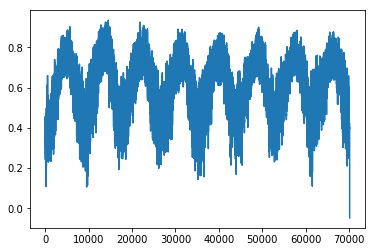

In [42]:
plt.plot(np.mean(weather_data_arrays['temperature'], axis=0))

In [43]:
print(len(normed_training_data_pairs[0][0]), len(normed_training_data_pairs[0][1]))

6321 24


temperature
current: 6321 next: 6758
precipProbability
current: 6758 next: 7195
apparentTemperature
current: 7195 next: 7632
humidity
current: 7632 next: 8069
windSpeed
current: 8069 next: 8506
visibility
current: 8506 next: 8943


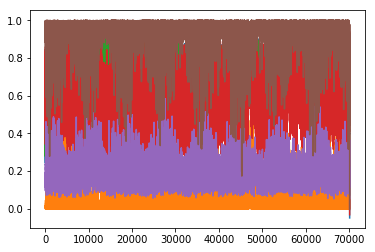

In [44]:
for feature in features_hourly:
    print(feature)
    temp_data_array = weather_data_arrays[feature]
    temps_train_array = temp_data_array[:,0:-8760]
    temps_test_array = temp_data_array[:,-8760:]
    
    print("current: " + str(len(normed_training_data_pairs[0][0])), "next: " + str(len(np.concatenate((normed_training_data_pairs[0][0], (temps_train_array[:,0+1:0+24]).flatten()), axis=0))))

    for i in range(len(normed_training_data_pairs)):
        p = normed_training_data_pairs[i]
        temps = (temps_train_array[:,i+1:i+24]).flatten()
        wp = np.concatenate((p[0], temps), axis=0)
        outp = (wp, p[1])
        normed_training_data_pairs[i] = outp
    #with open(outpath + "train/" + str(i) + "_all_weather_" + datatype + ".pck", 'wb') as d:
       # pickle.dump(outp, d)

    for i in range(len(normed_test_data_pairs)):
        p = normed_test_data_pairs[i]
        temps = (temps_test_array[:,i+1:i+24]).flatten()
        wp = np.concatenate((p[0], temps), axis=0)
        outp = (wp, p[1])
        normed_test_data_pairs[i] = outp
        #with open(outpath + "test/" + str(i) + "_all_weather_" + datatype + ".pck", 'wb') as d:
            #pickle.dump(outp, d)

In [45]:
print(len(normed_training_data_pairs[0][0]), len(normed_training_data_pairs[0][1]))

8943 24


In [46]:
for i in range(len(normed_training_data_pairs)):
    outp = normed_training_data_pairs[i]
    with open(writepath + "train/" + str(i) + "_all_weather_" + datatype + ".pck", 'wb') as d:
        pickle.dump(outp, d)
        
for i in range(len(normed_test_data_pairs)):
    outp = normed_test_data_pairs[i]
    with open(writepath + "test/" + str(i) + "_all_weather_" + datatype + ".pck", 'wb') as d:
        pickle.dump(outp, d)

In [64]:
allweatherhours = list(hourly_weather.keys())
print(len(allhours))

train_weatherhours = allweatherhours[0:-8760]
test_weatherhours = allweatherhours[-8760:]
print(len(allweatherhours))

70128
70128


In [65]:
len(normed_training_data_pairs)

61343

In [74]:
#training data pairs
weather_array_path = "/home/chase/projects/peakload/data/weather/ercot/major_cities/array_formatted/yearly_normed_arrays/"
outpath = "/home/chase/projects/peakload/data/ercot/weather_pairs/" + form + "_" + datatype + "/"

if not os.path.exists(outpath):
    os.mkdir(outpath)
if not os.path.exists(outpath + "train"):
    os.mkdir(outpath + "train")

#write them as you go
#weather_normed_training_data_pairs = []
hourly_keys = list(hourly_weather.keys())

#get the month from trainhours[i]

for i in range(len(normed_training_data_pairs)):
    pair = normed_training_data_pairs[i]
    p1 = np.nan_to_num(pair[0]).flatten()
    dtplus = trainhours[i+1]
    day = datetime.datetime(year=dtplus.year, month=dtplus.month, day=dtplus.day, hour=0, minute=0, second=0)
    day_weather_vec = daily_weather[day] #get the forecast
    #hourly_weather_vecs = []
    #for j in range(24):
    #    hourly_weather_vecs.append(hourly_weather[hourly_keys[i+j+1]])
        
    wforecast = day_weather_vec.flatten()
    #wforecast = np.concatenate((np.asarray(hourly_weather_vecs).flatten(), day_weather_vec.flatten()), axis=0)
    wf = np.nan_to_num(wforecast)
    
    with open(outpath + "/train/pair_" + str(i) + ".pck", 'wb') as d:
        pout = (np.concatenate((p1, wf), axis=0), pair[1].flatten())
        pickle.dump(pout, d)
    #weather_normed_training_data_pairs.append( (np.concatenate((p1, wf), axis=0), pair[1].flatten()) )

In [ ]:
if not os.path.exists(outpath):
    os.mkdir(outpath)
if not os.path.exists(outpath + "test"):
    os.mkdir(outpath + "test")

#test data pairs
#weather_normed_test_data_pairs = []

for i in range(len(normed_test_data_pairs)):
    pair = normed_test_data_pairs[i]
    p1 = np.nan_to_num(pair[0]).flatten()
    dtplus = testhours[i+1]
    day = datetime.datetime(year=dtplus.year, month=dtplus.month, day=dtplus.day, hour=0, minute=0, second=0)
    day_weather_vec = daily_weather[day] #get the forecast
    #hourly_weather_vecs = []
    #for j in range(24):
    #    hourly_weather_vecs.append(hourly_weather[test_weatherhours[i+j+1]])
        
    wforecast = day_weather_vec.flatten()
    #wforecast = np.concatenate((np.asarray(hourly_weather_vecs).flatten(), day_weather_vec.flatten()), axis=0)
    wf = np.nan_to_num(wforecast)
    
    with open(outpath + "/test/pair_" + str(i) + ".pck", 'wb') as d:
        if pout[0].shape[0] != 1679:
            print(pout[0].shape)
        pout = (np.concatenate((p1, wf), axis=0), pair[1].flatten())
        pickle.dump(pout, d)
    #weather_normed_test_data_pairs.append( (np.concatenate((p1, wf), axis=0), pair[1].flatten()) )

In [71]:
pout[0].shape

(1679,)

In [5]:
#write parameter objects to pck files
#without weather

model_name = "triple_hidden" #"triple_hidden"
form = "regional_formatted"
datatype = "load_features"

call = "python /home/chase/projects/peakload/src/python/train.py"
net =  "/home/chase/projects/peakload/src/python/nets/" + model_name + "/" + model_name + ".py"
#paramfile = "/home/chase/projects/peakload/src/python/nets/single_hidden/EWloss_h1_250_params.pck"
train_data_path = "/home/chase/projects/peakload/data/ercot/" + form + "/" + datatype + "/train"
test_data_path = "/home/chase/projects/peakload/data/ercot/" + form + "/" + datatype + "/test"

epochs = 300
batch_size = 200
lookback = 168*4 #one week in hours
losses = ["EW", "L1"]
hidden_1 = [1000]
hidden_2 = [500]
hidden_3 = [50]

train_test_file = open("/home/chase/projects/peakload/src/python/nets/" + model_name + "/train_and_test.sh", 'w')

i = 0
for loss in losses:
    id_ = str(random.randint(1000,9999))
    ident = model_name + "_" + id_
    h1 = hidden_1[i]
    h2 = hidden_2[i]
    h3 = hidden_3[i]
    params = {'LOOKBACK': lookback, 'HIDDEN_1': h1, 'HIDDEN_2': h2, 'HIDDEN_3': h3, 'LOSS': loss, 'EPOCHS': epochs, 'DATA': 'directory', 'BATCH_SIZE': batch_size, 'weather': False}
    parampath = "/home/chase/projects/peakload/src/python/nets/" + model_name + "/" + ident + "_params.pck"
    with open(parampath, 'wb') as p:
        pickle.dump(params, p)
    shcmd = " ".join([call, net, parampath, train_data_path, test_data_path, ident])
    train_test_file.write(shcmd + ";\n")
        
train_test_file.close()

In [3]:
#write parameter objects to pck files
#without weather

model_name = "tanh_deep" #"triple_hidden"
form = "regional_formatted"
datatype = "load_features_wplus"

call = "python /home/chase/projects/peakload/src/python/train.py"
net =  "/home/chase/projects/peakload/src/python/nets/" + model_name + "/" + model_name + ".py"
#paramfile = "/home/chase/projects/peakload/src/python/nets/single_hidden/EWloss_h1_250_params.pck"
train_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/" + form + "/" + datatype + "/train"
test_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/" + form + "/" + datatype + "/test"

epochs = 500
batch_size = 200
lookback = 168*4 #one week in hours
losses = ["EW"]
hidden_1 = [10000]
hidden_2 = [12000]
hidden_3 = [10000]
hidden_4 = [5000]
hidden_5 = [1000]
hidden_6 = [100]

train_test_file = open("/home/chase/projects/peakload/src/python/nets/" + model_name + "/train_and_test_weather.sh", 'w')

i = 0
for loss in losses:
    id_ = str(random.randint(1000,9999))
    ident = model_name + "_" + id_
    h1 = hidden_1[i]
    h2 = hidden_2[i]
    h3 = hidden_3[i]
    h4 = hidden_4[i]
    h5 = hidden_5[i]
    h6 = hidden_6[i]
    params = {'IDENT': ident, 'LOOKBACK': lookback, 'HIDDEN_1': h1, 'HIDDEN_2': h2, 'HIDDEN_3': h3, 'HIDDEN_4': h4, 'HIDDEN_5': h5, 'HIDDEN_6': h6, 'LOSS': loss, 'EPOCHS': epochs, 'DATA': 'directory', 'BATCH_SIZE': batch_size, 'weather': True}
    parampath = "/home/chase/projects/peakload/src/python/nets/" + model_name + "/" + ident + "_params.pck"
    with open(parampath, 'wb') as p:
        pickle.dump(params, p)
    shcmd = " ".join([call, net, parampath, train_data_path, test_data_path, ident])
    train_test_file.write(shcmd + ";\n")
        
train_test_file.close()

In [18]:
with open("/home/chase/projects/peakload/src/python/nets/" + model_name + "/" + ident + "_params.pck", 'rb') as d:
    print(pickle.load(d))
    

{'IDENT': 'triple_hidden_3080', 'LOOKBACK': 672, 'HIDDEN_1': 10000, 'HIDDEN_2': 5000, 'HIDDEN_3': 100, 'LOSS': 'EW', 'EPOCHS': 300, 'DATA': 'directory', 'BATCH_SIZE': 200, 'weather': True}


In [2]:
with open("/home/chase/projects/peakload/data/ercot/formatted/load_features_normed_test_data_pairs.pck", 'rb') as d:
    normed_test_data_pairs = pickle.load(d)
    
with open("/home/chase/projects/peakload/data/ercot/formatted/load_features_normed_training_data_pairs.pck", 'rb') as d:
    normed_training_data_pairs = pickle.load(d)

In [5]:
len(normed_test_data_pairs) + 168 + 24

8760

In [26]:
#shuffle training/test data pairs, split out validation

random.shuffle(weather_normed_training_data_pairs)
training_pairs = weather_normed_training_data_pairs[0:int(0.9*float(len(weather_normed_training_data_pairs)))]
val_pairs = weather_normed_training_data_pairs[int(0.9*float(len(weather_normed_training_data_pairs))):]

random.shuffle(weather_normed_test_data_pairs)

In [27]:
weather_normed_training_data_pairs[0][0].shape

(17030,)

In [3]:
class linear_net(nn.Module):
    def __init__(self):
        super(linear_net, self).__init__()
        self.D_in = training_pairs[0][0].shape[0]
        self.H1 = 10000 #increased hidden size
        #can try additional hidden layer
        self.H2 = 5000
        self.H3 = 500
        self.D_out = 24
        self.l1 = nn.Linear(self.D_in, self.H1)
        self.l2 = nn.Linear(self.H1, self.H2)
        self.l3 = nn.Linear(self.H2, self.H3)
        self.l4 = nn.Linear(self.H3, self.D_out)
    
    def forward(self, x):
        x = F.sigmoid(self.l1(x))
        x = F.tanh(self.l2(x))
        x = F.sigmoid(self.l3(x))
        x = self.l4(x)
        return(x)

In [22]:
#write parameter objects to pck files

call = "python /home/chase/projects/peakload/src/python/train.py"
net =  "/home/chase/projects/peakload/src/python/nets/single_hidden/single_hidden.py"
#paramfile = "/home/chase/projects/peakload/src/python/nets/single_hidden/EWloss_h1_250_params.pck"
train_data_path = "/home/chase/projects/peakload/data/ercot/formatted/load_features_normed_training_data_pairs.pck"
test_data_path = "/home/chase/projects/peakload/data/ercot/formatted/load_features_normed_test_data_pairs.pck"
model_name = "single_sigmoid"
id_ = str(random.randint(1000,9999))
ident = model_name + "_" + id_

epochs = 100
lookback = 168 #one week in hours
losses = ["L1", "EW"]
hidden_1 = [250, 500, 1000]

train_test_file = open("/home/chase/projects/peakload/src/python/nets/single_hidden/train_and_test.sh", 'w')

for loss in losses:
    for h in hidden_1:
        params = {'LOOKBACK': lookback, 'HIDDEN_1': h, 'LOSS': loss, 'EPOCHS': epochs, 'DATA': 'file'}
        parampath = "/home/chase/projects/peakload/src/python/nets/single_hidden/" + loss + "loss_h1_" + str(h) + "_params.pck"
        with open(parampath, 'wb') as p:
            pickle.dump(params, p)
        shcmd = " ".join([call, net, parampath, train_data_path, test_data_path, model_name])
        train_test_file.write(shcmd + ";\n")
        
train_test_file.close()

In [25]:
#write parameter objects to pck files

call = "python /home/chase/projects/peakload/src/python/train.py"
net =  "/home/chase/projects/peakload/src/python/nets/tanh_hidden/tanh_hidden.py"
#paramfile = "/home/chase/projects/peakload/src/python/nets/single_hidden/EWloss_h1_250_params.pck"
train_data_path = "/home/chase/projects/peakload/data/ercot/formatted/load_features_normed_training_data_pairs.pck"
test_data_path = "/home/chase/projects/peakload/data/ercot/formatted/load_features_normed_test_data_pairs.pck"
model_name = "tanh_sigmoid"

epochs = 100
lookback = 168 #one week in hours
losses = ["EW"]
hidden_1 = [250, 500, 1000, 1500]
hidden_2 = [250, 500, 1000, 1500]
hidden_3 = [250, 500, 1000, 1500]

train_test_file = open("/home/chase/projects/peakload/src/python/nets/tanh_hidden/train_and_test.sh", 'w')

for loss in losses:
    for i in range(len(hidden_2)):
        for j in range(i, len(hidden_1)):
            h1 = hidden_1[j]
            h2 = hidden_2[i]
            h3 = hidden_3[i]
            params = {'LOOKBACK': lookback, 'HIDDEN_1': h1, 'HIDDEN_2': h2, 'HIDDEN_3': h3, 'LOSS': loss, 'EPOCHS': epochs, 'DATA': 'file'}
            parampath = "/home/chase/projects/peakload/src/python/nets/tanh_hidden/" + loss + "loss_h1_" + str(h1) + "_h2_" + str(h2) + "_h3_" + str(h3) + "_params.pck"
            with open(parampath, 'wb') as p:
                pickle.dump(params, p)
            shcmd = " ".join([call, net, parampath, train_data_path, test_data_path, model_name])
            train_test_file.write(shcmd + ";\n")
        
train_test_file.close()

In [5]:
#write parameter objects to pck files

call = "python /home/chase/projects/peakload/src/python/train.py"
net =  "/home/chase/projects/peakload/src/python/nets/tanh_hidden/tanh_hidden.py"
#paramfile = "/home/chase/projects/peakload/src/python/nets/single_hidden/EWloss_h1_250_params.pck"
train_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/training"
test_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/test"
model_name = "tanh_sigmoid_weather"

epochs = 100
lookback = 168 #one week in hours
losses = ["EW", "L1"]
hidden_1 = [250, 500, 1000, 1500, 2500, 5000, 7500, 10000, 20000]
hidden_2 = [250, 500, 1000, 1500, 2500, 5000, 7500]
hidden_3 = [50, 100, 250, 500, 1000, 1500, 2500, 5000]

train_test_file = open("/home/chase/projects/peakload/src/python/nets/tanh_hidden/train_and_test.sh", 'w')

for loss in losses:
    for i in range(len(hidden_2)):
        for j in range(i, len(hidden_1)):
            h1 = hidden_1[j]
            h2 = hidden_2[i]
            h3 = hidden_3[i]
            params = {'LOOKBACK': lookback, 'HIDDEN_1': h1, 'HIDDEN_2': h2, 'HIDDEN_3': h3, 'LOSS': loss, 'EPOCHS': epochs, 'DATA': 'directory'}
            parampath = "/home/chase/projects/peakload/src/python/nets/tanh_hidden/" + loss + "loss_h1_" + str(h1) + "_h2_" + str(h2) + "_h3_" + str(h3) + "_params.pck"
            with open(parampath, 'wb') as p:
                pickle.dump(params, p)
            shcmd = " ".join([call, net, parampath, train_data_path, test_data_path, model_name])
            train_test_file.write(shcmd + ";\n")
        
train_test_file.close()

In [ ]:
#write parameter objects to pck files

call = "python /home/chase/projects/peakload/src/python/train.py"
net =  "/home/chase/projects/peakload/src/python/nets/tanh_hidden/tanh_hidden.py"
#paramfile = "/home/chase/projects/peakload/src/python/nets/single_hidden/EWloss_h1_250_params.pck"
train_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/training"
test_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/test"
model_name = "tanh_sigmoid_weather"

epochs = 100
lookback = 168 #one week in hours
losses = ["EW", "L1"]
hidden_1 = [250, 500, 1000, 1500, 2500, 5000, 7500, 10000, 20000]
hidden_2 = [250, 500, 1000, 1500, 2500, 5000, 7500]
hidden_3 = [50, 100, 250, 500, 1000, 1500, 2500, 5000]

train_test_file = open("/home/chase/projects/peakload/src/python/nets/tanh_hidden/train_and_test.sh", 'w')

for loss in losses:
    for i in range(len(hidden_2)):
        for j in range(i, len(hidden_1)):
            h1 = hidden_1[j]
            h2 = hidden_2[i]
            h3 = hidden_3[i]
            params = {'LOOKBACK': lookback, 'HIDDEN_1': h1, 'HIDDEN_2': h2, 'HIDDEN_3': h3, 'LOSS': loss, 'EPOCHS': epochs, 'DATA': 'directory'}
            parampath = "/home/chase/projects/peakload/src/python/nets/tanh_hidden/" + loss + "loss_h1_" + str(h1) + "_h2_" + str(h2) + "_h3_" + str(h3) + "_params.pck"
            with open(parampath, 'wb') as p:
                pickle.dump(params, p)
            shcmd = " ".join([call, net, parampath, train_data_path, test_data_path, model_name])
            train_test_file.write(shcmd + ";\n")
        
train_test_file.close()

In [5]:
#write parameter objects to pck files

model_name = "tanh_dropout"
call = "python /home/chase/projects/peakload/src/python/train.py"
net =  "/home/chase/projects/peakload/src/python/nets/" + model_name + "/" + model_name + ".py"
#paramfile = "/home/chase/projects/peakload/src/python/nets/single_hidden/EWloss_h1_250_params.pck"
train_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/training"
test_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/test"

epochs = 100
lookback = 168 #one week in hours
losses = ["EW", "L1"]
hidden_1 = [1500, 2500, 5000, 7500, 10000, 20000]
hidden_2 = [250, 1000, 2500, 5000]
hidden_3 = [25, 100, 200, 250]

train_test_file = open("/home/chase/projects/peakload/src/python/nets/" + model_name + "/train_and_test.sh", 'w')

for loss in losses:
    for i in range(len(hidden_2)):
        for j in range(i, len(hidden_1)):
            h1 = hidden_1[j]
            h2 = hidden_2[i]
            h3 = hidden_3[i]
            params = {'LOOKBACK': lookback, 'HIDDEN_1': h1, 'HIDDEN_2': h2, 'HIDDEN_3': h3, 'LOSS': loss, 'EPOCHS': epochs, 'DATA': 'directory'}
            parampath = "/home/chase/projects/peakload/src/python/nets/" + model_name + "/" + loss + "loss_h1_" + str(h1) + "_h2_" + str(h2) + "_h3_" + str(h3) + "_params.pck"
            with open(parampath, 'wb') as p:
                pickle.dump(params, p)
            shcmd = " ".join([call, net, parampath, train_data_path, test_data_path, model_name])
            train_test_file.write(shcmd + ";\n")
        
train_test_file.close()

In [8]:
#write parameter objects to pck files

model_name = "tanh_dropout"
call = "python /home/chase/projects/peakload/src/python/train.py"
net =  "/home/chase/projects/peakload/src/python/nets/" + model_name + "/" + model_name + ".py"
#paramfile = "/home/chase/projects/peakload/src/python/nets/single_hidden/EWloss_h1_250_params.pck"
train_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/training"
test_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/test"

epochs = 100
lookback = 168 #one week in hours
losses = ["EW", "L1"]
hidden_1 = [1500, 2500, 5000, 7500, 10000, 20000]
hidden_2 = [1000, 1500, 2500, 5000, 7500]
hidden_3 = [50, 500, 1000]
hidden_4 = [50, 500, 1000]
hidden_5 = [50, 500, 1000]
hidden_6 = [50, 100]

train_test_file = open("/home/chase/projects/peakload/src/python/nets/" + model_name + "/train_and_test.sh", 'w')

for loss in losses:
    for i in range(len(hidden_2)):
        for j in range(i, len(hidden_1)):
            h1 = hidden_1[j]
            h2 = hidden_2[i]
            h3 = hidden_3[i]
            h4 = hidden_4[i]
            h5 = hidden_5[i]
            h6 = hidden_6[i]
            params = {'LOOKBACK': lookback, 'HIDDEN_1': h1, 'HIDDEN_2': h2, 'HIDDEN_3': h3, 'HIDDEN_4': h4, 'HIDDEN_5': h5, 'HIDDEN_6': h6, 'LOSS': loss, 'EPOCHS': epochs, 'DATA': 'directory'}
            parampath = "/home/chase/projects/peakload/src/python/nets/" + model_name + "/" + loss + "loss_h1_" + str(h1) + "_h2_" + str(h2) + "_h3_" + str(h3) + "_h4_" + str(h4) + "_h5_" + str(h5) + "_h6_" + str(h6) + "_params.pck"
            with open(parampath, 'wb') as p:
                pickle.dump(params, p)
            shcmd = " ".join([call, net, parampath, train_data_path, test_data_path, model_name])
            train_test_file.write(shcmd + ";\n")
        
train_test_file.close()

IndexError: list index out of range

In [10]:
#write parameter objects to pck files

model_name = "tanh_dropout"
form = "formatted"
datatype = "midnight_daymax_load_features"

call = "python /home/chase/projects/peakload/src/python/train.py"
net =  "/home/chase/projects/peakload/src/python/nets/" + model_name + "/" + model_name + ".py"
#paramfile = "/home/chase/projects/peakload/src/python/nets/single_hidden/EWloss_h1_250_params.pck"
train_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/" + form + "_" + datatype + "/training"
test_data_path = "/home/chase/projects/peakload/data/ercot/weather_pairs/" + form + "_" + datatype + "/test"

epochs = 100
batch_size = 100
lookback = 168 #one week in hours
losses = ["EW"]
hidden_1 = [15000]
hidden_2 = [7500]
hidden_3 = [1000]
hidden_4 = [1000]
hidden_5 = [1000]
hidden_6 = [50]

train_test_file = open("/home/chase/projects/peakload/src/python/nets/" + model_name + "/train_and_test.sh", 'w')

i = 0
for loss in losses:
    id_ = str(random.randint(1000,9999))
    ident = model_name + "_" + id_
    h1 = hidden_1[i]
    h2 = hidden_2[i]
    h3 = hidden_3[i]
    #h4 = hidden_4[i]
    #h5 = hidden_5[i]
    #h6 = hidden_6[i]
    #params = {'LOOKBACK': lookback, 'HIDDEN_1': h1, 'HIDDEN_2': h2, 'HIDDEN_3': h3, 'HIDDEN_4': h4, 'HIDDEN_5': h5, 'HIDDEN_6': h6, 'LOSS': loss, 'EPOCHS': epochs, 'DATA': 'directory'}
    params = {'LOOKBACK': lookback, 'HIDDEN_1': h1, 'HIDDEN_2': h2, 'HIDDEN_3': h3, 'LOSS': loss, 'EPOCHS': epochs, 'DATA': 'directory', 'BATCH_SIZE': batch_size}
    parampath = "/home/chase/projects/peakload/src/python/nets/" + model_name + "/" + ident + "_params.pck"
    with open(parampath, 'wb') as p:
        pickle.dump(params, p)
    shcmd = " ".join([call, net, parampath, train_data_path, test_data_path, ident])
    train_test_file.write(shcmd + ";\n")
        
train_test_file.close()

In [ ]:
#write a bash file to train all

In [21]:
class l_linear_net(nn.Module):
    def __init__(self):
        super(linear_net, self).__init__()
        self.D_in = lookback * 28
        self.H1 = 250
        self.H2 = 150
        self.H3 = 50
        self.D_out = 24
        self.l1 = nn.Linear(self.D_in, self.H1)
        self.l2 = nn.Linear(self.H1, self.H2)
        self.l3 = nn.Linear(self.H2, self.H3)
        self.l4 = nn.Linear(self.H3, self.D_out)
    
    def forward(self, x):
        x = F.sigmoid(self.l1(F.dropout(x)))
        x = F.sigmoid(self.l2(x))
        x = F.softmax(self.l3(x))
        x = self.l4(x)
        return(x)

In [29]:
def batch_sample_list(datalist, batchsize):
    remainder = len(datalist) % batchsize
    diff = batchsize - remainder
    tail = datalist[-diff:] + datalist[0:remainder]
    out = [ datalist[i*batchsize:(i+1)*batchsize] for i in range(int(float(len(datalist))/float(batchsize)))]
    out = out + [tail]
    return(out)

def torch_reshape_data(databatch):
    inputs = []
    labels = []
    for sample in databatch:
        inputs.append(sample[0].flatten())
        labels.append(sample[1].flatten())
    return(torch.Tensor(np.asarray(inputs)), torch.Tensor(np.asarray(labels)))

In [23]:
any(np.array([1,2,3]) > 2)

True

In [30]:
def batched_model_score(net_obj, datalist, thresh=0.85, batchsize=100):
    recs = []
    precs = []
    thresh_losses_low = []
    thresh_losses_high = []
    set_losses = []
    
    #batchdata
    batches = batch_sample_list(datalist, batchsize)
    
    #do prediction on datalist
    for i, data, in enumerate(batches):
        inputs, labels = torch_reshape_data(data)
        labels = Variable(labels.cuda())
        inputs = Variable(inputs.cuda())
        outputs = net_obj(inputs)
        loss = criterion(outputs, labels)
        set_losses.append(loss.data[0])
        
        labels = labels.data.cpu().numpy()
        outputs = outputs.data.cpu().numpy()
        
        for i in range(outputs.shape[0]):
            l = labels[i,:]
            o = outputs[i,:]
            
            if any(l > thresh):
                rec = binary_rec(l, o, thresh)
                recs.append(rec)
            if any(o > thresh):
                prec = binary_prec(l, o, thresh)
                precs.append(prec)
                
            loss_low = thresh_loss(l, o, thresh)
            loss_high = thresh_loss(l, o, 0.95)
            
            thresh_losses_low.append(np.mean(loss_low))
            thresh_losses_high.append(np.mean(loss_high))
    
    if len(recs) < 1:
        r = np.nan
    else:
        r = np.mean(recs)
    if len(precs) < 1:
        p = np.nan
    else:
        p = np.mean(precs)
    if np.isnan(r) or np.isnan(p):
        batch_f1 = np.nan
    else:
        batch_f1 = f1_score(r, p)
    
    low_thresh_mean_loss = np.nanmean(thresh_losses_low)
    high_thresh_mean_loss = np.nanmean(thresh_losses_high)
    mean_set_loss = np.mean(set_losses)
    
    ret = {"batch_recall": r, "batch_precision": p, "batch_f1": batch_f1, "low_thresh_mean_loss": low_thresh_mean_loss, "high_thresh_mean_loss": high_thresh_mean_loss, "mean_set_loss": mean_set_loss}          
    return(ret)

def print_model_scores(scores, name):
    print("====" + name + "====")
    for k in scores:
        print(k + ": " + str(scores[k]))
    print("=================\n")
    
    
def binary_rec(true, pred, thresh=0.85):
    true_pos = 0
    pred_pos = 0
    for i in range(len(true)):
        val = true[i]
        if val >= thresh:
            true_pos += 1
            pred_val = pred[i]
            if pred_val >= thresh:
                pred_pos += 1
    if true_pos == 0:
        return(0)
    else:
        return(float(pred_pos)/float(true_pos))
    
def binary_prec(true, pred, thresh=0.85):
    pos = 0
    true_pos = 0
    for i in range(len(pred)):
        val = pred[i]
        if val >= thresh:
            pos += 1
            comp_val = true[i]
            if comp_val >= thresh:
                true_pos += 1
    if pos == 0:
        return(0)
    else:
        return(float(true_pos)/float(pos))

def thresh_loss(true, pred, thresh=0.85):
    out = []
    for i in range(len(true)):
        val = true[i]
        if val >= thresh:
            loss = np.abs(val - pred[i])
            out.append(loss)
    return(out)

def f1_score(rec, prec):
    return(2.0/((1/rec) + (1/prec)))

def set_loss(net_obj, data):
    inputs, labels = torch_reshape_data(data)
    labels = Variable(labels.cuda())
    outputs = net_obj(Variable(inputs.cuda()))
    loss = criterion(outputs, labels)
    return(loss.data[0])

In [31]:
def model_score(net_obj, datalist, threshes=[0.85, 0.95, 0.99, 0.999], batchsize=100):
    #model scoring is on L1 loss
    recs = {}
    precs = {}
    thresh_losses = {}
    for t in threshes:
        thresh_losses[t] = []
        recs[t] = []
        precs[t] = []
    set_losses = []
    
    #for also recording weighted loss function later
    criterion_l1 = nn.L1Loss()
    
    #do prediction on datalist
    inputs, labels = torch_reshape_data(datalist)
    labels = Variable(labels.cuda())
    inputs = Variable(inputs.cuda())
    outputs = net_obj(inputs)
    loss = criterion_l1(outputs, labels)
    set_losses.append(loss.data[0])
    
    labels = labels.data.cpu().numpy()
    outputs = outputs.data.cpu().numpy()
    
    for i in range(outputs.shape[0]):
        l = labels[i,:]
        o = outputs[i,:]
        
        for t in threshes:
            if any(l > t):
                rec = binary_rec(l, o, t)
                recs[t].append(rec)
            if any(o > t):
                prec = binary_prec(l, o, t)
                precs[t].append(prec)
  
            tl = thresh_loss(l, o, t)
            thresh_losses[t].append(np.nanmean(tl))
    
    for t in thresh_losses:
        thresh_losses[t] = np.nanmean(thresh_losses[t])
        if len(recs[t]) < 1:
            recs[t] = np.nan
        else:
            recs[t] = np.nanmean(recs[t])
        if len(precs[t]) < 1:
            precs[t] = np.nan
        else:
            precs[t] = np.nanmean(precs[t])

    mean_set_loss = np.nanmean(set_losses)
    
    ret = {"batch_recall": recs, "batch_precision": precs, "thresh_losses": thresh_losses, "mean_set_loss": mean_set_loss}          
    return(ret)

In [25]:
import math

torch.exp(torch.Tensor([0, math.log(2)])) * torch.exp(torch.Tensor([0, math.log(2)]))


 1
 4
[torch.FloatTensor of size 2]

In [32]:
def expw_mae_loss(input, target, base=10.0):
    base = Variable(torch.Tensor([base])).type_as(target)
    return(( (input - target).abs() * torch.pow(base, target) ).sum() / input.data.nelement() )

In [33]:
def train(net_obj, loss_fnc, opt_fnc, traindata, valdata, batchsize=100, epochs=50):  
    train_batches = batch_sample_list(traindata, batchsize)
    num_batches = len(train_batches)
    tenth = int(num_batches/10)
    
    training_epoch_loss = []
    train_epoch_set_loss = []
    val_epoch_set_loss = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_batches):
            inputs, labels = torch_reshape_data(data)

            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda()) #they need to be .cuda() with each training epoch

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net_obj(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]

            #training loss
            #print("epoch " + str(epoch) + " ,iter " + str(i) + ": " + str(running_loss))
            #training_epoch_loss.append(running_loss)
        
        print("==epoch " + str(epoch) + "==")
        train_samp = random.randint(0,num_batches-1)
        train_set_loss = set_loss(net_obj, train_batches[train_samp])
        train_epoch_set_loss.append(train_set_loss)
        print("training set sampled loss: " + str(train_set_loss))
        val_set_loss = set_loss(net_obj, valdata)
        val_epoch_set_loss.append(val_set_loss)
        print("validation set loss: " + str(val_set_loss))
       
    #sampled epoch set loss
    print("\n")
    print("Model results")
    
    train_model_scores = batched_model_score(net_obj, traindata)
    print_model_scores(train_model_scores, "training data scores")
    
    val_model_scores = batched_model_score(net_obj, valdata)
    print_model_scores(val_model_scores, "validation data scores")
                
    return(training_epoch_loss, train_epoch_set_loss, val_epoch_set_loss)

In [ ]:
#switch nans to -1's

In [34]:
batch_size = 100 #batch size

net = linear_net().cuda()

criterion = expw_mae_loss #nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
train_losses, train_accs, test_accs = train(net, criterion, optimizer, training_pairs, val_pairs)

==epoch 0==
training set sampled loss: 0.8030710816383362


In [60]:
test_model_scores = model_score(net, weather_normed_test_data_pairs)
print_model_scores(test_model_scores, "test data scores")

/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: Mean of empty slice


====test data scores====
batch_recall: {0.85: 0.8184080665931602, 0.95: 0.9420365780671124, 0.99: 0.9969432314410481, 0.999: 1.0}
batch_precision: {0.85: 0.8928108353067051, 0.95: 0.6117134316069153, 0.99: 0.15997180162558833, 0.999: 0.007426426426426425}
thresh_losses: {0.85: 0.042240818868496385, 0.95: 0.05805267103670435, 0.99: 0.08449693017515857, 0.999: 0.11889468113037005}
mean_set_loss: 0.1052764281630516



In [ ]:
def l1_loss(input, target, size_average=True):
    return _functions.thnn.L1Loss.apply(input, target, size_average)ls


class L1Loss(_Loss):
    r"""Creates a criterion that measures the mean absolute value of the
    element-wise difference between input `x` and target `y`:

    :math:`{loss}(x, y)  = 1/n \sum |x_i - y_i|`

    `x` and `y` arbitrary shapes with a total of `n` elements each.

    The sum operation still operates over all the elements, and divides by `n`.

    The division by `n` can be avoided if one sets the constructor argument
    `size_average=False`.

    Args:
        size_average (bool, optional): By default, the losses are averaged
           over observations for each minibatch. However, if the field
           size_average is set to False, the losses are instead summed for
           each minibatch. Default: True

    Shape:
        - Input: :math:`(N, *)` where `*` means, any number of additional
          dimensions
        - Target: :math:`(N, *)`, same shape as the input

    Examples::

        >>> loss = nn.L1Loss()
        >>> input = autograd.Variable(torch.randn(3, 5), requires_grad=True)
        >>> target = autograd.Variable(torch.randn(3, 5))
        >>> output = loss(input, target)
        >>> output.backward()
    """
    def forward(self, input, target):
        _assert_no_grad(target)
        return F.l1_loss(input, target, size_average=self.size_average)

0.8888888888888888


array([ 0.22591324,  0.28630137,  0.3872146 ,  0.45502284,  0.48664382,
        0.47203195,  0.43481734,  0.38972601,  0.36004567,  0.34406394,
        0.33755708,  0.36883563,  0.43584475,  0.45285389,  0.40958905,
        0.3303653 ,  0.23504566,  0.16575342,  0.11312786,  0.08070777,
        0.0609589 ,  0.0553653 ,  0.05947489,  0.08413242], dtype=float32)

array([ 0.27877405,  0.29841518,  0.31782278,  0.3170574 ,  0.30463257,
        0.30868047,  0.3124792 ,  0.3071259 ,  0.31804854,  0.31793466,
        0.31255594,  0.30287418,  0.30706862,  0.27466702,  0.26765308,
        0.23752765,  0.21457636,  0.19224998,  0.19455633,  0.19908968,
        0.2263395 ,  0.23829129,  0.25208017,  0.26730546], dtype=float32)

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [323]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.c1 = nn.Conv1d(input_size, hidden_size, 2)
        self.p1 = nn.AvgPool1d(2)
        self.c2 = nn.Conv1d(hidden_size, hidden_size, 1)
        self.p2 = nn.AvgPool1d(2)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=0.01)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, inputs, hidden):
        batch_size = inputs.size(1)
        
        # Turn (seq_len x batch_size x input_size) into (batch_size x input_size x seq_len) for CNN
        inputs = inputs.transpose(0, 1).transpose(1, 2)

        # Run through Conv1d and Pool1d layers
        c = self.c1(inputs)
        p = self.p1(c)
        c = self.c2(p)
        p = self.p2(c)

        # Turn (batch_size x hidden_size x seq_len) back into (seq_len x batch_size x hidden_size) for RNN
        p = p.transpose(1, 2).transpose(0, 1)
        
        p = F.tanh(p)
        output, hidden = self.gru(p, hidden)
        conv_seq_len = output.size(0)
        output = output.view(conv_seq_len * batch_size, self.hidden_size) # Treating (conv_seq_len x batch_size) as batch_size for linear layer
        output = F.tanh(self.out(output))
        output = output.view(conv_seq_len, -1, self.output_size)
        return output, hidden

input_size = 20
hidden_size = 50
output_size = 7
batch_size = 5
n_layers = 2
seq_len = 15

rnn = RNN(input_size, hidden_size, output_size, n_layers=n_layers)

inputs = Variable(torch.rand(seq_len, batch_size, input_size)) # seq_len x batch_size x 
outputs, hidden = rnn(inputs, None)
print('outputs', outputs.size()) # conv_seq_len x batch_size x output_size
print('hidden', hidden.size()) # n_layers x batch_size x hidden_size

outputs torch.Size([3, 5, 7])
hidden torch.Size([2, 5, 50])


In [329]:
inputs.data.shape

torch.Size([15, 5, 20])